# Retail Clustering Visualization

In addition to recommendations we can use SVD to dimensionally reduce the rating matrix. This is necessary because clustering algorithms don't work well on very high dimensional data. 

Previously we multipled $\Sigma$ into the matrices as $\sqrt{\Sigma}\tilde{\mathbf{U}}$ and $\sqrt{\Sigma}\tilde{\mathbf{V}}^T$. By incorporating the magnitudes we have vectors that can be accurately clustered. 

In this example we will use [KMeans][KMEANS] to cluster the customer vectors. We will generate approximations from the centroids to see what ratings each cluster represents. Finally we will use [t-SNE][TSNE] to generate 2D and 3D visualizations of the 10 dimensional vectors.

[TSNE]:<http://scikit-learn.org/stable/modules/manifold.html#t-sne>
[KMEANS]:<http://scikit-learn.org/stable/modules/clustering.html#k-means>

### Steps

1. Load customer vectors from `svd_cust_vec` into a DataFrame.
1. Generate K-Means clusters.
1. Save clusters centroids to `svd_kmeans` table.
1. Generate recommendations for each centroid and determine the labels.
1. Use t-SNE to visualize in 2D.
1. Use t-SNE to visualize in 3D.

### Prerequsites

You should have run the [svd_calc.ipynb](svd_calc.ipynb) notebook to generate the vector tables.

In [16]:
# Local libraries should automatically reload
%reload_ext autoreload
%autoreload 1

import sys 
sys.path.append('../KJIO')
import numpy as np
import pandas as pd
%aimport kapi_io

pd.options.display.max_colwidth = 100

# create tables in this schema
SCHEMA = 'SVD'

### Load customer vectors

Load `svd_cust_vec` into a DataFrame containing a 10 dimensional vector for each customer.

In [2]:
# load input table
_table_df = kapi_io.load_df('svd_cust_vec')
_table_df.head()

Getting 65531 records from <svd_cust_vec>.......
Records Retrieved: (65531, 11)


,customer_id,U0,U1,U2,U3,U4,U5,U6,U7,U8,U9
0,11152,-0.000987,-0.005919,-0.016551,0.002591,-0.006140,-0.017519,-0.005205,0.015159,0.016626,-0.196109
1,12976,-0.000404,-0.001781,-0.004311,-0.000810,-0.000784,-0.005010,-0.001469,0.002630,0.004393,-0.025996
2,14254,-0.000113,-0.000180,-0.001239,-0.002130,-0.000394,-0.000141,-0.000391,0.000155,0.001258,-0.000676
3,14675,-0.002395,-0.019058,-0.062350,0.034907,-0.029845,-0.000411,0.002203,0.004710,0.003852,-0.067047
4,15657,-0.001306,-0.002113,-0.004605,-0.001511,-0.001459,-0.002829,-0.002562,0.003995,0.001969,-0.016334


### Set clustering parameters

In [3]:
# number of clusters to find
CUST_CLUSTERS = 6

# numer of columns to keep (dimension n-1)
VECTOR_END_IDX = 6

# convert to numpty matrix
_table_np = _table_df.iloc[:,1:VECTOR_END_IDX].values.astype(np.float64)

print('Input customer vectors: ', _table_np.shape)

Input customer vectors:  (65531, 5)


### Calculate K-Means

The [KMeans][KMEANS] algorithm clusters data by trying to separate samples in N groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. 

*Note: K-menas struggles to find centroids for higher dimensional data but can be more accurate then Gaussian Mixture when it works well.*

[KMEANS]:<http://scikit-learn.org/stable/modules/clustering.html#k-means>

In [4]:
from sklearn.cluster import KMeans

_cust_means = KMeans(n_clusters=CUST_CLUSTERS,
                    verbose=False,
                     max_iter=1000,
                    random_state=0).fit(_table_np)

_cust_clusters = _cust_means.cluster_centers_
_cust_labels = _cust_means.labels_

print('KMeans clusters: ', _cust_clusters.shape)
print('KMeans labels: ', _cust_labels.shape)

KMeans clusters:  (6, 5)
KMeans labels:  (65531,)


### Gaussian Mixture Clustering

A [GaussianMixture][GMMODEL] model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.

*Note: To use this you need to comment out KMenas and uncomment GaussianMixture*

[GMMODEL]: <http://scikit-learn.org/stable/modules/mixture.html#mixture>

In [5]:
# from sklearn.mixture import GaussianMixture

# _cust_mixture = GaussianMixture(
#     n_components=CUST_CLUSTERS, 
#     n_init=10, 
#     random_state=1).fit(_table_np)

# _cust_clusters = _cust_mixture.means_
# _cust_labels = _cust_mixture.predict(_table_np)

# print('GaussianMixture clusters: ', _cust_clusters.shape)
# print('GaussianMixture labels: ', _cust_labels.shape)

### Create a combined dataframe with counts and centroids

In [13]:
# get counts of means
_labels_df = pd.DataFrame(_cust_labels, columns=['IDX'])
_counts_df = pd.DataFrame(_labels_df.groupby('IDX').size(), columns=['COUNT'])

# create a dataframe of centroids
_centroids_df = pd.DataFrame(_cust_clusters, 
                             columns=_table_df.columns[1:VECTOR_END_IDX],
                             index=_counts_df.index)

# create a combined dataframe
_means_df = pd.concat([_counts_df, _centroids_df], axis=1).reset_index()
_means_df

,IDX,COUNT,U0,U1,U2,U3,U4
0,0,59374,-0.000923,-0.003468,-0.009243,0.001444,-0.002705
1,1,1066,-0.553824,0.010483,0.007333,-0.000911,-0.004102
2,2,2428,-0.008571,-0.302637,0.036792,-0.011587,0.007358
3,3,1584,-0.005646,-0.046991,-0.234499,0.151393,-0.142227
4,4,399,-0.016971,-0.035448,-0.364657,-0.057885,0.566655
5,5,680,-0.001452,-0.010250,-0.158610,-0.389691,-0.142973


### Save k-means table to Kinetica

In [14]:
kapi_io.save_df(_means_df, 'svd_kmeans', SCHEMA, _is_replicated=True)

Dropping table: <svd_kmeans>
Creating replicated  table: <svd_kmeans>
Column 0: <IDX> (long) []
Column 1: <COUNT> (long) []
Column 2: <U0> (double) []
Column 3: <U1> (double) []
Column 4: <U2> (double) []
Column 5: <U3> (double) []
Column 6: <U4> (double) []
Inserted rows into <SVD.svd_kmeans>: 6


### Generate labels for centroids

The labels of the t-SNE plot need to be determined manually from the drug ratings for each centriod. The below SQL will generate 4 approximations for each centroid.

Approximations are calculated by taking the dot product of each centroid (as if it was a customer vector) with the product matrix. This is similar to what was done in [svd_recommend.ipynb](svd_recommend.ipynb).

$\mathbf{\tilde{a}}_i = (\sqrt{\Sigma} \mathbf{\tilde{u}}_i) \cdot (\sqrt{\Sigma} \mathbf{\tilde{v}}_i^T) $

In [29]:
%aimport kodbc_io
_cnxn = kodbc_io.get_odbc()

_sql = """
select top 4
    cv.IDX,
    iv.product_parent,
    cv.COUNT,
    rp.product_title,
    (cv.U0 * iv.V0)
    + (cv.U1 * iv.V1) 
    + (cv.U2 * iv.V2) 
    + (cv.U3 * iv.V3) 
    + (cv.U4 * iv.V4)
    as item_rating
from svd_kmeans as cv, svd_item_vec as iv
join amazon_products rp
    on rp.product_parent = iv.product_parent
where cv.idx = {}
order by item_rating desc
"""

_final_df = pd.DataFrame()

for _idx in _means_df.index.values:
    _new_sql = _sql.format(_idx)
    print('Calculating index: {}'.format(_idx))
    _rows_df = pd.read_sql(_new_sql, _cnxn)
    _final_df = _final_df.append(_rows_df)

_cnxn.close()

_final_df = _final_df.set_index(['IDX'])
_final_df

Connected to GPUdb ODBC Server (6.2.0.12.20180720232954)
Calculating index: 0
Calculating index: 1
Calculating index: 2
Calculating index: 3
Calculating index: 4
Calculating index: 5


,product_parent,COUNT,product_title,item_rating
IDX,,,,
0,826484350,59374,"Smith's PP1 Pocket Pal Multifunction Sharpener, Grey",0.116173
0,114878519,59374,Mirka Bulldog Gold 5-Inch 8-Hole 60 Grit Grip Vacuum Discs,0.039340
0,655034668,59374,CLC Custom Leathercraft 125 Handyman Flex Grip Work Gloves,0.035846
0,655034668,59374,"CLC Custom Leathercraft 125M Handyman Flex Grip Work Gloves, Medium",0.035846
1,174267532,1066,MagLite LED 2-Cell D Flashlight,10.550399
1,174267532,1066,MagLite Heavy-Duty Incandescent 2-Cell D Flashlight in Display Box,10.550399
1,341803157,1066,"Maglite Mini Incandescent 2-Cell AA Flashlight, Black",0.373371
1,805377466,1066,"Maglite Black Universal Mounting Brackets for D-Cell Flashlight, 2 pk",0.260852
2,844836744,2428,UltraFire? 1000 LM WF-502B CREE XM-L T6 5-Mode LED Flashlight Torch (With Batteries and Charger),4.832773


### Manually entered labels for the clusters

By examining the approximation of each cluster we can manually determine a label for each cluster.

*note: These need to be updated after running on a new data set*

In [20]:
_cbar_labels = [ 
    'Other',
    'MagLite LED',
    'UltraFire? 1000',
    'Multifunction Sharpener',
    'Handyman Flex Grip',
    'Vacuum Discs' ]

### 2D t-SNE Visualization

We can't plot 10 dimensional vectors so we use [t-SNE][TSNE] (t-distributed Stochastic Neighbor Embedding) to generate a 2D representation.

[TSNE]:<http://scikit-learn.org/stable/modules/manifold.html#t-sne>

In [18]:
from sklearn.manifold import TSNE

# This algorithm is slow so we only use the first N points.
TSNE_POINTS = 1000

tsne_2d = TSNE(
    n_components=2, 
    verbose=1, 
    #perplexity=80, 
    #n_iter=600, 
    random_state=0
)

tsne_2d_results = tsne_2d.fit_transform(_table_np[:TSNE_POINTS])
print('Done', tsne_2d_results.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000525
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.381512
[t-SNE] Error after 1000 iterations: 0.462567
Done (1000, 2)


### Plot the 2D t-SNE representation

We plot the t-SNE points using colors to identify each of the clusters.

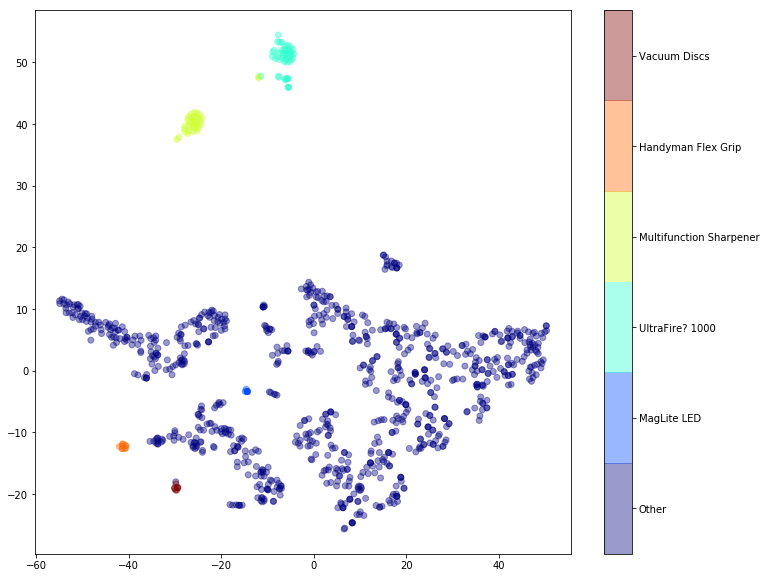

In [21]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,10))
sc = plt.scatter(
    x=tsne_2d_results[:,1],
    y=tsne_2d_results[:,0], 
    c=_cust_labels[:TSNE_POINTS], 
    alpha=0.4, 
    cmap=plt.cm.get_cmap("jet", CUST_CLUSTERS)
)
plt.clim(-0.5, CUST_CLUSTERS - 0.5)
cbar = plt.colorbar(sc)
cbar.ax.set_yticklabels(_cbar_labels)
plt.show()

### 3D t-SNE Visualization

Generate a 3D representation of the 10 dimensional customer vectors.

In [23]:
from sklearn.manifold import TSNE
TSNE_3D_POINTS = 2000

tsne_3d = TSNE(
    n_components=3, 
    verbose=1, 
    #perplexity=80, 
    #n_iter=600, 
    random_state=0
)
tsne_3d_results = tsne_3d.fit_transform(_table_np[:TSNE_POINTS])
print('Done', tsne_3d_results.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000525
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.023811
[t-SNE] Error after 1000 iterations: 0.361365
Done (1000, 3)


# Plot the 3D data representation

We use plotly to generate an interactive 3D view of the same data that was used for the 2D view. 

*note: Running this requires a [plotly API key][PLOTLY]. You will need to add your key and un-comment the line with `set_credentials_file`.*

[PLOTLY]: <https://plot.ly/python/getting-started/>

In [27]:
import plotly as pt

pt.offline.init_notebook_mode(connected=True)

# uncomment this and put your API key here
#pt.tools.set_credentials_file(username='x', api_key='x')

scatter_3d = pt.graph_objs.Scatter3d(
    x=tsne_3d_results[:,0],
    y=tsne_3d_results[:,1],
    z=tsne_3d_results[:,2],
    mode='markers',
    marker=dict(
        size=4,
        color=_cust_labels[:TSNE_3D_POINTS],
        colorscale='Viridis',
        opacity=0.5,
        showscale=True,
        colorbar=dict( 
            ticks='outside'
        )
    )
)

scatter_fig = pt.graph_objs.Figure(
    data=[scatter_3d], 
    layout=pt.graph_objs.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
)

pt.plotly.iplot(scatter_fig, filename='svd-tsne-3d')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~chadj/0 or inside your plot.ly account where it is named 'svd-tsne-3d'
